<a href="https://colab.research.google.com/github/mrpep/my-colabs/blob/master/formant_analysis_with_opensmile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/naxingyu/opensmile.git
!wget https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav
%%writefile opensmile/config/formants.conf

 ///////////////////////////////////////////////////////////////////////////
 // openSMILE configuration file "demo1"				  //
 ///////////////////////////////////////////////////////////////////////////

 ;===== component manager configuration (= list of enabled components!) =====

[componentInstances:cComponentManager]
 // this line configures the default data memory:
instance[dataMemory].type = cDataMemory
instance[waveSource].type = cWaveSource
instance[framer].type = cFramer
instance[windower].type = cWindower
instance[fft_20].type = cTransformFFT
instance[spec_resample].type = cSpecResample
instance[lpc].type = cLpc
instance[formants].type = cFormantLpc
instance[csvSink].type = cCsvSink
printLevelStats = 1
nThreads = 1

// ============= component configuration sections begin here ==============

  ;;;; default (template) configuration section for component 'cWaveSource' ;;;;
[waveSource:cWaveSource]
writer.dmLevel = wave
period = 0
filename = \cm[inputfile(I){input.wav}:file name of the input wave file]
monoMixdown = 1 

[framer:cFramer]
reader.dmLevel=wave
writer.dmLevel=frame_20
frameSize = 0.020
frameStep = 0.010
frameCenterSpecial = left

[windower:cWindower]
reader.dmLevel=frame_20
writer.dmLevel=win_20
winFunc=hamming

[fft_20:cTransformFFT]
reader.dmLevel=win_20
writer.dmLevel=fft_20
 ; for compatibility with 2.2.0 and older versions
zeroPadSymmetric = 0

[spec_resample:cSpecResample]
// use fftcG60 ?  H25 has faster resampling
reader.dmLevel=fft_20 
writer.dmLevel=fft_resampled
targetFs = 11000

[lpc:cLpc]
reader.dmLevel=fft_resampled
writer.dmLevel=lpc
p=11
method=acf
lpGain=0
saveLPCoeff=1
residual=0
forwardFilter=0
lpSpectrum=0

[formants:cFormantLpc]
reader.dmLevel=lpc
writer.dmLevel=formants
saveIntensity=1
saveBandwidths=1
maxF=5500.0
minF=50.0
nFormants=5
useLpSpec=0
medianFilter=0
octaveCorrection=0

  ;;;; default (template) configuration section for component 'cCsvSink' ;;;;
[csvSink:cCsvSink]
reader.dmLevel = formants
filename = \cm[outputfile(O){output.csv}:file name of the output CSV file]
delimChar = ;
append = 0
timestamp = 1
number = 1
printHeader = 1
 

// ################### END OF openSMILE CONFIG FILE ######################



Overwriting opensmile/config/formants.conf


In [ ]:
SMILE_PATH = '/content/opensmile/bin/linux_x64_standalone_libstdc6/SMILExtract'
SMILECONF_PATH = '/content/opensmile/config'
CONFIG_PATH = SMILECONF_PATH + '/formants.conf'

WAV_PATH = '/content/OSR_us_000_0010_8k.wav'

cmd = '{SMILExtract} -C {conf} -I {wavfile} --outputfile {output}'.format(
        SMILExtract=SMILE_PATH, conf=CONFIG_PATH, wavfile=WAV_PATH, output='out.csv')

!$cmd

(MSG) [2] in SMILExtract : openSMILE starting!
(MSG) [2] in SMILExtract : config file is: /content/opensmile/config/formants.conf
(MSG) [2] in cComponentManager : successfully registered 96 component types.
(ERROR) [1] in instance 'formants' : lpGain not found as input field, cannot compute formant frame intensity, disabling it now!
==> LEVEL 'wave'  +++  Buffersize(frames) = 16001  +++  nReaders = 1
==> LEVEL 'frame_20'  +++  Buffersize(frames) = 3  +++  nReaders = 1
==> LEVEL 'win_20'  +++  Buffersize(frames) = 3  +++  nReaders = 1
==> LEVEL 'fft_20'  +++  Buffersize(frames) = 3  +++  nReaders = 1
==> LEVEL 'fft_resampled'  +++  Buffersize(frames) = 3  +++  nReaders = 1
==> LEVEL 'lpc'  +++  Buffersize(frames) = 3  +++  nReaders = 1
==> LEVEL 'formants'  +++  Buffersize(frames) = 3  +++  nReaders = 1
(MSG) [2] in cComponentManager : successfully finished createInstances
                                 (8 component instances were finalised, 1 data memories were finalised)
(MSG) [2] i

In [ ]:
import pandas as pd

formants_data = pd.read_csv('out.csv',delimiter=';')

In [ ]:
formants_data

,frameIndex,frameTime,formantFreqLpc[1],formantFreqLpc[2],formantFreqLpc[3],formantFreqLpc[4],formantFreqLpc[5],formantBandwidthLpc[1],formantBandwidthLpc[2],formantBandwidthLpc[3],formantBandwidthLpc[4],formantBandwidthLpc[5]
0,0,0.00,983.4827,1954.509,2911.315,4422.622,0.000,1191.351,1171.2390,728.1134,967.4680,0.0000
1,1,0.01,981.9990,1680.774,2878.969,4276.975,0.000,1395.217,1278.1960,643.1526,1365.6600,0.0000
2,2,0.02,964.8700,1731.025,3056.765,4861.356,0.000,1605.209,1089.8280,503.5069,932.7711,0.0000
3,3,0.03,888.6388,1886.471,2933.499,4479.867,0.000,1188.618,982.6722,625.1351,1391.9720,0.0000
4,4,0.04,288.2349,1374.241,2196.178,2999.468,4820.128,2264.026,1196.9760,2590.4500,963.3381,866.7626
...,...,...,...,...,...,...,...,...,...,...,...,...
3356,3356,33.56,961.2266,1865.941,2899.750,4308.429,0.000,1311.077,910.9643,662.5164,636.7319,0.0000
3357,3357,33.57,1017.5260,2068.191,3069.696,4363.275,0.000,1105.194,964.5826,867.5979,857.2123,0.0000
3358,3358,33.58,1140.1450,2083.670,2811.369,4249.325,0.000,1282.454,1813.1380,1105.8420,863.3602,0.0000
3359,3359,33.59,1215.4890,2044.547,2673.961,4267.365,0.000,1304.903,2177.9120,1086.5580,899.8531,0.0000


Mean formantFreqLpc[1]: 782.7715030675388
Mean formantFreqLpc[2]: 1785.7384752752182
Mean formantFreqLpc[3]: 2778.963130318356
Mean formantFreqLpc[4]: 3938.617662730848
Mean formantFreqLpc[5]: 4856.578294407895


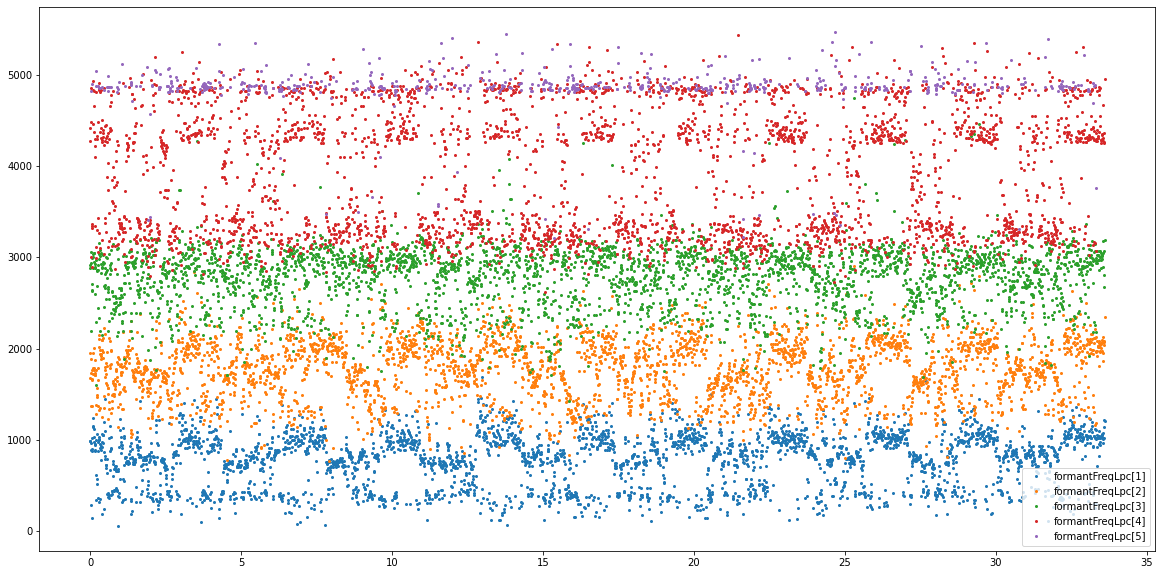

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
for formant in ['formantFreqLpc[{}]'.format(i) for i in range(1,6)]:
  formant_mean = formants_data[formant][formants_data[formant]>0].mean()
  print("Mean {}: {}".format(formant,formant_mean))
  plt.plot(formants_data['frameTime'][formants_data[formant]>0],formants_data[formant][formants_data[formant]>0],'o',label=formant,markersize=2)
plt.legend()

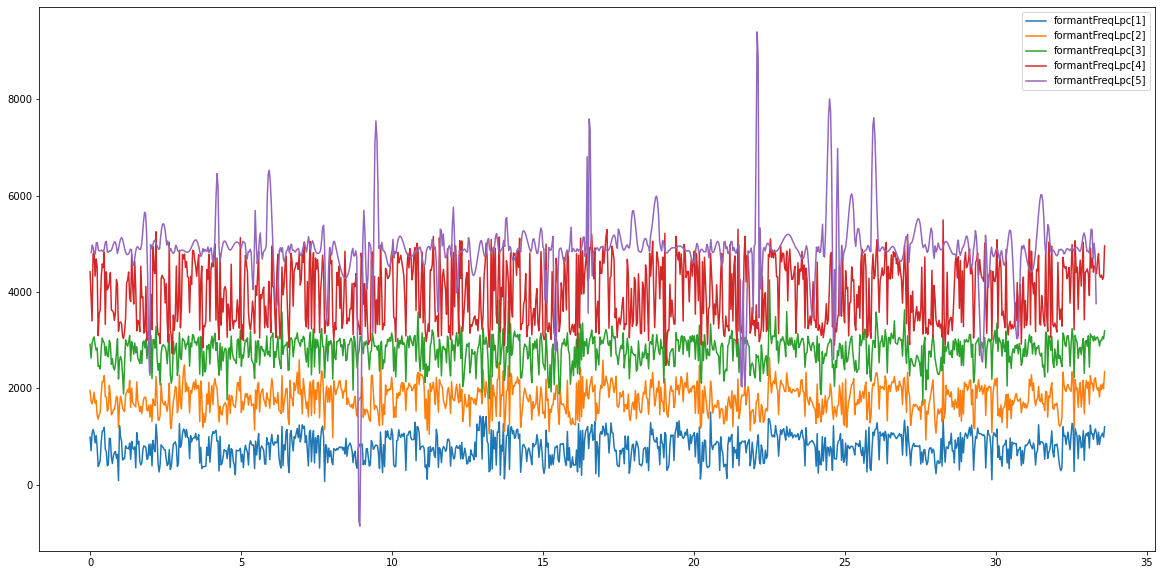

In [ ]:
from scipy.interpolate import splrep, splev
import numpy as np

plt.figure(figsize=(20,10))
for formant in ['formantFreqLpc[{}]'.format(i) for i in range(1,6)]:
  x = formants_data['frameTime'][formants_data[formant]>0]
  x_new = np.linspace(x.min(),x.max(),1000)
  y = formants_data[formant][formants_data[formant]>0]
  f = splrep(x, y)
  plt.plot(x_new,splev(x_new,f,der=0),'-',label=formant,markersize=2)
plt.legend()
